# ARBOLES DE DECISION

Como las SVMs, los *árboles de decisión* son versátiles algoritmos de Machine Learning que pueden ejecutar tanto tareas de clasificación como de regresión, e incluso tareas multioutput. Son algoritmos muy poderoso, capaces de entrenar datasets complejos. Por ejemplo, en el capítulo 2 entrenamos un modelo `DecisionTreeRegressor` en el dataset de viviendas de California, ajustandolo perfectamente (en realidad, sobreajustándolo).

Los Arboles de Decisión son también los componentes fundamentales de los Bosques Aleatorios, los cuales se encuentran entre los algoritmos de Machine Learning más poderosos disponibles en la actualidad.

En este capítulo comenzaremos discutiendo cómo entrenar, visualizar y hacer predicciones con árboles de decisión. Luego iremos a través del algoritmo de entrenamiento CART usado por Scikit-Learn y veremos cómo regularizar árboles y a usarlos en tareas de regresión. Finalmente, discutiremos algunas de las limitaciones de los árboles de decisión.

# Entrenar y visualizar un Arbol de Decisión

Para comprender los árboles de decisión, contruyamos uno y echemos un vistazo a cómo realiza sus predicciones. El siguiente código entrena un `DecisionTreeClassifier` en el dataset de Iris:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # largo y ancho de pétalo
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Podemos visualizar el árbol de decisión entrenado usando el método `export_graphviz()` para devolver un fichero de definición de grafo llamado *iris_tree.dot*:

In [3]:
#from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="./images/ch06/iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
        )

Nuestro primer árbol de decisión se vería asi:

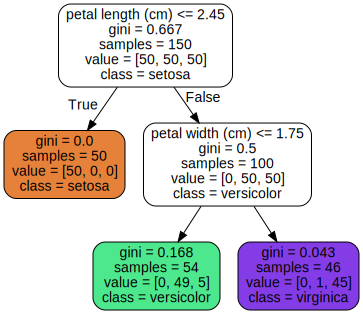

In [4]:
from graphviz import Source
Source.from_file("./images/Ch06/iris_tree.dot")

También podemos convertir este archivo *.dot* a formatos diversos como PDF o PNG usando el la herramienta de línea de comandos `dot` del paquete [graphwiz](http://www.graphviz.org/). Esta línea de comando convierte el archivo *.dot* en un archivo de imagen *.pgn*:

    $ dot -Tpng iris_tree.dot -o iris_tree.png

# Hacer predicciones

Veamos cómo el árbol representado en la figura anterior hace predicciones. Supongamos que encontramos una flor de iris y queremos clasificarla. Empezamos en el *nodo raíz* (profundidad 0, en la cima): este nodo pregunta si la longitud del pétalo de la flor es menor de 2,45 cm. Si es así, nos movemos abajo hacia el nodo hijo izquierdo (profundidad 1, izquierda). En este caso, es un *nodo hoja* (es decir, no tiene nodos hijos), por lo que no hacemos preguntas: simplemente miramos la clase pronosticada para ese nodo y el árbol de decisión predice que nuestra flor es una Iris-Setosa (`class=setosa`).

Ahora supongamos que encontramos otra flor, pero esta vez la longitud es mayor que 2,45 cm. Debemos movernos abajo hacia el nodo hijo derecho (profundidad 1, derecha), que no es un nodo hoja, por tanto, nos hace una pregunta: ¿es el ancho de pétalo menor que 1,75 cm? Si es que sí, entonces nuestra flor los más probable es que sea una Iris-Versicolor (profundidad 2, izquierda). Si es que no, es probablemente una Iris-Virginica (profundidad 2, derecha). Es realmente así de simple.

---

Una de las muchas cualidades de los Arboles de Decisión es que requieren muy pocos datos de preparación. En particular, no requieren escalado de características o centrado de todas ellas.

---

El atributo `samples` de un nodo cuenta a cuántas instancias de entrenamiento se aplica. Por ejemplo, 100 instancias de entrenamiento tienen una longitud de pétalo mayor que 2,45 cm (profundidad 1, derecha), de las cuales 54 tienen un ancho de pétalo menor que 1,75 cm (profundidad 2, izquiera). El atributo `value` de un nodo nos dice a cuántas instancias de entrenamiento de cada clase aplica ese nodo: por ejemplo, el nodo inferior derecho aplica a 0 Iris-Setosa, 1 Iris-Versicolor y a 45 Iris-Virginica. Finalmente, el atributo `gini`de un nodo mide su *impureza*: un nodo es "puro" (`gini=0`) si todas las instancias de entrenamiento que aplica pertenecen a la misma clase. Por ejemplo, dado que el nodo de profundidad 1 izquierdo aplica solo a instancias de entrenamiendo Iris-Setosa, es puro y su puntuación `gini` es 0. La siguiente ecuación muestra cómo el algoritmo de entrenamiento calcula la puntuación gini $G_i$ del nodo $i^{esimo}$. Por ejemplo, el nodo de profundidad 2 izquierdo tiene un `gini` igual a $1 - (\frac{0}{54})^2 - (\frac{49}{54})^2 - (\frac{5}{54})^2 \approx 0,168$. En breve discutiremos otra *medida de la impureza*.

***Impureza Gini***

$G_i = 1 - \displaystyle\sum_{k=1}^n p_{i,k}^2$

+ $p_{i,k}$ es el ratio de instancias de la clase *k* entre las instancias de entrenamiento en el i-ésimo nodo.

---

Scikit-Learn usa el algoritmo CART que produce solo *árboles binarios*: nodos no-hojas que siempre tienes dos hijos (es decir, preguntas que solo tienen respuestas de sí/no). Sin embargo, otros algoritmos como ID3 pueden producir árboles de decisión con nodos que tienen más de dos hijos.

---

La siguiente figura muestra los límites de decisión de este árbol de decisión. La línea vertical gruesa representa el límite de decisión del nodo raíz (profundidad 0): longitud de pétalo = 2,45 cm Dado que el área izquierda es pura (solo Iris-Setosa), no se puede dividir más. Sin embargo, el área derecha es impura, por tanto el nodo de profundidad 1 derecho la divide en ancho de pétalo = 1,75 cm. (representado por la línea de rayas). Dado que `max_depth` estaba establecido a 2, el árbol de decisión de detiene allí. Sin embargo, si establecemos `max_depth` a 3, entonces los dos nodos de profundidad 2 agregarían cada uno otro límite de decisión (representado por las líneas punteadas).

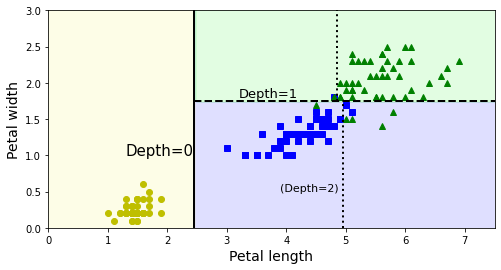

In [9]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.30, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(3.90, 0.5, "(Depth=2)", fontsize=11);

---

***Interpretación del modelo: caja blanca versus caja negra***

Como podemos ver, los árboles de decisión son bastante intuitivos y sus decisiones son fáciles de interpretar. Tales modelos a menudo se denominan *modelos de caja blanca*. Por el contrario, como veremos, los bosques aleatorios o las redes neuronales se consideran generalmente *modelos de caja negra*. Hacen grandes predicciones y se pueden comprobar fácilmente los cálculos que realizan para hacer esas predicciones, sin embargo, generalmente es difícil explicar en términos simples por qué se hicieron las predicciones. Por ejemplo, si una red neuronal dice que una persona en particual aparece en una fotografía, es difícil saber que es lo que realmente contribuye a esta predicción: ¿el modelo ha reconocido los ojos de la persona? ¿su boca? ¿su nariz? ¿sus zapatos? ¿o incluso el sofá en el que estaba sentada?. A la inversa, los árboles de decisión proporcionan unas reglas de clasificación simples y fáciles que pueden ser aplicadas manualmente si fuera necesario (por ejemplo, para la clasificación de flores).

---